<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

## Problem Statement

Many homeowners are looking to maximize their value of their home to increase their sale price. Most homeowners only look at what home features can increase the value of their home but neglect to look at what they can do to minimize features that decrease the value of their home. We will explore what home features have an affect on home sale prices.

## Contents:
- [Background](#Background)
- [Exploratory Data Analysis & Cleaning](#EDA-and-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Preprocessing](#Preprocessing)
- [Model and Evaluation](#Model-and-Evaluation)
- [Predictions](#Prediction)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Background

The Ames Housing Dataset contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. The original data was used for tax assessment purposes but has since been used to predict the sale price of a home. The data has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, 20 continuous variables, 2 observation identifiers, and 2930 observations. 79 of the columns represent home features and each observation represents a sale. Review the data descriptions [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

## EDA and Cleaning

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
pd.options.display.max_columns = 99

In [3]:
train = pd.read_csv('../datasets/train.csv', keep_default_na=False, na_values='')
train.columns = train.columns.str.lower().str.replace(' ','_')
test = pd.read_csv('../datasets/test.csv', keep_default_na=False, na_values='')
test.columns = test.columns.str.lower().str.replace(' ','_')

In [4]:
train.shape, test.shape

((2051, 81), (878, 80))

Test dataset does not have saleprice because that is what we are looking to predict

In [5]:
train.drop(train.index[train['gr_liv_area'] > 4000], inplace=True)

Deleted outliers that were recommended in the data description

In [6]:
train['saleprice'].describe()

count      2049.000000
mean     181479.018058
std       79295.913255
min       12789.000000
25%      129800.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

Average saleprice is $181,479.02

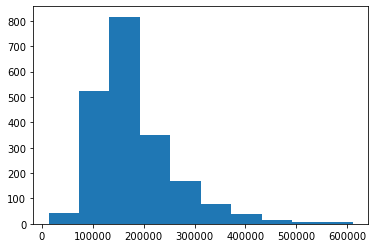

In [7]:
plt.hist(train['saleprice'],bins=10);

Right-skewed

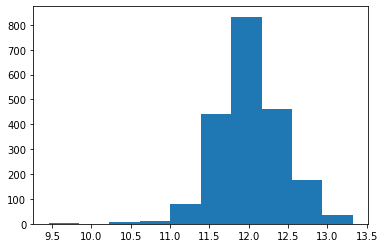

In [8]:
plt.hist(np.log(train['saleprice']), bins=10);

Exploring a more normalized Saleprice 

In [9]:
train[train['gr_liv_area'] > 4000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice


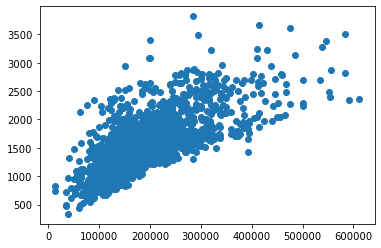

In [10]:
plt.scatter(train['saleprice'], train['gr_liv_area']);

In [11]:
train.dtypes

id                int64
pid               int64
ms_subclass       int64
ms_zoning        object
lot_frontage    float64
                 ...   
misc_val          int64
mo_sold           int64
yr_sold           int64
sale_type        object
saleprice         int64
Length: 81, dtype: object

In [12]:
train.corr().tail(1)

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
saleprice,-0.051416,-0.255068,-0.087331,0.35553,0.303744,0.803462,-0.097093,0.572405,0.550872,0.520023,0.445764,0.016222,0.190231,0.664819,0.648252,0.248826,-0.041608,0.719463,0.284763,-0.045571,0.538225,0.283372,0.137145,-0.125472,0.509775,0.473783,0.534514,0.648667,0.655483,0.327629,0.338545,-0.135713,0.048721,0.134555,0.025805,-0.010323,0.032508,-0.015174,1.0


Looking at all correlations between numerical features and saleprice

In [13]:
train['total_baths'] = train['bsmt_full_bath'] + train['bsmt_half_bath'] + train['full_bath'] + train['half_bath']
train['home_sqft'] = train['gr_liv_area'] + train['bsmtfin_sf_1'] + train['bsmtfin_sf_2']
train['total_porches'] = train['open_porch_sf'] + train['enclosed_porch'] + train['3ssn_porch'] + train['screen_porch']
train['bsmt'] = train['total_bsmt_sf'] - (train['bsmtfin_sf_1'] + train['bsmtfin_sf_2']+train['bsmt_unf_sf'])
train['sqft'] = train['gr_liv_area'] - (train['1st_flr_sf'] + train['2nd_flr_sf']+ train['low_qual_fin_sf'])
train['bsmt'].unique(), train['sqft'].unique()            

(array([ 0., nan]), array([0]))

- Home square footage only includes liveable spaces 
    - Does not include porch, garage, pools, or unfinished basements https://www.apartmenttherapy.com/house-square-footage-meaning-36734380
- Doubled checked meaning of basement and square footage

In [14]:
test['total_baths'] = test['bsmt_full_bath'] + test['bsmt_half_bath'] + test['full_bath'] + test['half_bath']
test['home_sqft'] = test['gr_liv_area'] + test['bsmtfin_sf_1'] + test['bsmtfin_sf_2']
test['total_porches'] = test['open_porch_sf'] + test['enclosed_porch'] + test['3ssn_porch'] + test['screen_porch']

In [15]:
numerical = [col for col in train.columns if train[col].dtypes != 'object' and col != 'id' and col !='pid']

categorical = [col for col in train.columns if train[col].dtypes == 'object']

Separating numerical and categorical data for exploratory analysis

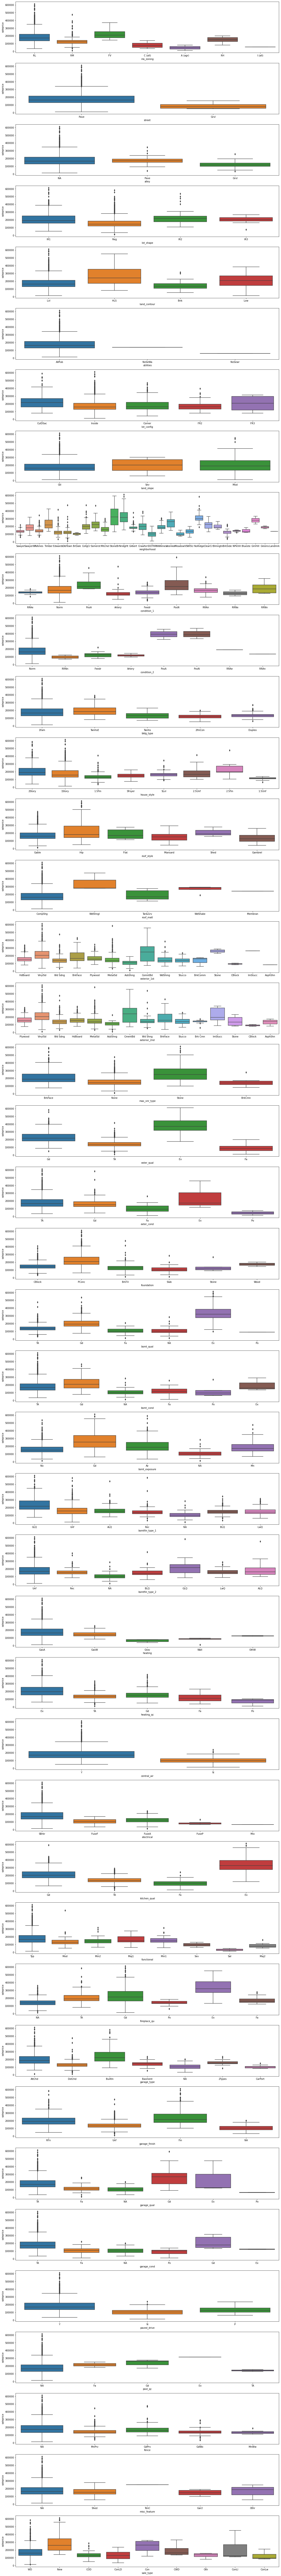

In [16]:
fig, ax = plt.subplots(42, 1, figsize=(20,200))
sns.boxplot(x=train['ms_zoning'], y=train['saleprice'], ax=ax[0])
sns.boxplot(x=train['street'], y=train['saleprice'], ax=ax[1])
sns.boxplot(x=train['alley'], y=train['saleprice'], ax=ax[2])
sns.boxplot(x=train['lot_shape'], y=train['saleprice'], ax=ax[3])
sns.boxplot(x=train['land_contour'], y=train['saleprice'], ax=ax[4])
sns.boxplot(x=train['utilities'], y=train['saleprice'], ax=ax[5])
sns.boxplot(x=train['lot_config'], y=train['saleprice'], ax=ax[6])
sns.boxplot(x=train['land_slope'], y=train['saleprice'], ax=ax[7])
sns.boxplot(x=train['neighborhood'], y=train['saleprice'], ax=ax[8])
sns.boxplot(x=train['condition_1'], y=train['saleprice'], ax=ax[9])
sns.boxplot(x=train['condition_2'], y=train['saleprice'], ax=ax[10])
sns.boxplot(x=train['bldg_type'], y=train['saleprice'], ax=ax[11])
sns.boxplot(x=train['house_style'], y=train['saleprice'], ax=ax[12])
sns.boxplot(x=train['roof_style'], y=train['saleprice'], ax=ax[13])
sns.boxplot(x=train['roof_matl'], y=train['saleprice'], ax=ax[14])
sns.boxplot(x=train['exterior_1st'], y=train['saleprice'], ax=ax[15])
sns.boxplot(x=train['exterior_2nd'], y=train['saleprice'], ax=ax[16])
sns.boxplot(x=train['mas_vnr_type'], y=train['saleprice'], ax=ax[17])
sns.boxplot(x=train['exter_qual'], y=train['saleprice'], ax=ax[18])
sns.boxplot(x=train['exter_cond'], y=train['saleprice'], ax=ax[19])
sns.boxplot(x=train['foundation'], y=train['saleprice'], ax=ax[20])
sns.boxplot(x=train['bsmt_qual'], y=train['saleprice'], ax=ax[21])
sns.boxplot(x=train['bsmt_cond'], y=train['saleprice'], ax=ax[22])
sns.boxplot(x=train['bsmt_exposure'], y=train['saleprice'], ax=ax[23])
sns.boxplot(x=train['bsmtfin_type_1'], y=train['saleprice'], ax=ax[24])
sns.boxplot(x=train['bsmtfin_type_2'], y=train['saleprice'], ax=ax[25])
sns.boxplot(x=train['heating'], y=train['saleprice'], ax=ax[26])
sns.boxplot(x=train['heating_qc'], y=train['saleprice'], ax=ax[27])
sns.boxplot(x=train['central_air'], y=train['saleprice'], ax=ax[28])
sns.boxplot(x=train['electrical'], y=train['saleprice'], ax=ax[29])
sns.boxplot(x=train['kitchen_qual'], y=train['saleprice'], ax=ax[30])
sns.boxplot(x=train['functional'], y=train['saleprice'], ax=ax[31])
sns.boxplot(x=train['fireplace_qu'], y=train['saleprice'], ax=ax[32])
sns.boxplot(x=train['garage_type'], y=train['saleprice'], ax=ax[33])
sns.boxplot(x=train['garage_finish'], y=train['saleprice'], ax=ax[34])
sns.boxplot(x=train['garage_qual'], y=train['saleprice'], ax=ax[35])
sns.boxplot(x=train['garage_cond'], y=train['saleprice'], ax=ax[36])
sns.boxplot(x=train['paved_drive'], y=train['saleprice'], ax=ax[37])
sns.boxplot(x=train['pool_qc'], y=train['saleprice'], ax=ax[38])
sns.boxplot(x=train['fence'], y=train['saleprice'], ax=ax[39])
sns.boxplot(x=train['misc_feature'], y=train['saleprice'], ax=ax[40])
sns.boxplot(x=train['sale_type'], y=train['saleprice'], ax=ax[41]);

Reviewing boxplot for correlation between categorical features and saleprice to determine which feature can create an accurate predicitive model. Those with larger spread were chosen.

In [17]:
train.isnull().sum().sort_values(ascending = False).loc[lambda x: x >0]

lot_frontage      330
garage_yr_blt     114
mas_vnr_type       22
mas_vnr_area       22
bsmt_exposure       4
bsmt_half_bath      2
bsmt_full_bath      2
total_baths         2
bsmtfin_type_2      2
bsmt_qual           1
garage_area         1
garage_finish       1
bsmtfin_type_1      1
bsmt_cond           1
garage_cond         1
bsmtfin_sf_1        1
bsmtfin_sf_2        1
bsmt_unf_sf         1
total_bsmt_sf       1
garage_qual         1
garage_cars         1
bsmt                1
home_sqft           1
dtype: int64

In [18]:
test.isnull().sum().sort_values(ascending = False).loc[lambda x: x >0]

lot_frontage     160
garage_yr_blt     45
electrical         1
mas_vnr_type       1
mas_vnr_area       1
garage_finish      1
dtype: int64

In [19]:
corr_saleprice = [col for col in numerical if train['saleprice'].corr(train[col]) > .5]
corr_val = [train['saleprice'].corr(train[col]) for col in numerical if train['saleprice'].corr(train[col]) > .5]

df_corr = pd.DataFrame(columns=['feature','correlation'])
df_corr['feature'] = corr_saleprice
df_corr['correlation'] = corr_val
df_corr.sort_values(by='correlation', ascending=False).head()

,feature,correlation
12,saleprice,1.000000
0,overall_qual,0.803462
14,home_sqft,0.763171
6,gr_liv_area,0.719463
4,total_bsmt_sf,0.664819


Utilized list comprehensions to create a dataframe that only consists of numerical features that have a 0.5 or higher correlation with sale price 

In [20]:
categorical_new = ['street', 'neighborhood', 'condition_2', 'roof_matl','exter_qual', 'exter_cond', 'bsmt_qual', 
                 'central_air', 'kitchen_qual', 'fireplace_qu','garage_qual', 'garage_cond']

Picked categorical features that showed spread between  values in boxplot

In [21]:
X_new = train[['overall_qual', 'year_built','year_remod/add','mas_vnr_area','total_bsmt_sf',
                '1st_flr_sf','gr_liv_area','full_bath','totrms_abvgrd','garage_yr_blt','garage_cars',
                 'garage_area','total_baths','home_sqft', 'total_porches', 'street', 'neighborhood', 
               'condition_2', 'roof_matl', 'exter_qual', 'exter_cond', 'bsmt_qual', 'central_air', 
               'kitchen_qual','fireplace_qu','garage_qual', 'garage_cond']]

In [22]:
y_new = train['saleprice']

In [23]:
X_new_train, X_new_test, y_new_train, y_new_test= train_test_split(X_new,y_new,random_state=123)
X_new_train.shape, X_new_test.shape, test.shape

((1536, 27), (513, 27), (878, 83))

In [24]:
X_new_train.head()

,overall_qual,year_built,year_remod/add,mas_vnr_area,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,garage_yr_blt,garage_cars,garage_area,total_baths,home_sqft,total_porches,street,neighborhood,condition_2,roof_matl,exter_qual,exter_cond,bsmt_qual,central_air,kitchen_qual,fireplace_qu,garage_qual,garage_cond
554,4,1971,1971,0.0,858.0,872,872,1,5,1974.0,4.0,480.0,1.0,872.0,0,Pave,NAmes,Norm,CompShg,TA,TA,TA,Y,TA,NA,TA,TA
196,7,2008,2009,140.0,1450.0,1450,1450,2,6,2008.0,3.0,788.0,2.0,1450.0,93,Pave,SawyerW,Norm,CompShg,Gd,TA,Gd,Y,Gd,NA,TA,TA
746,5,1958,1958,260.0,1560.0,1560,1560,2,8,1958.0,2.0,484.0,2.0,1560.0,0,Pave,NAmes,Norm,CompShg,TA,TA,TA,Y,TA,NA,TA,TA
1674,8,2004,2005,344.0,1143.0,1143,2473,2,9,2004.0,3.0,852.0,3.0,2473.0,151,Pave,NridgHt,Norm,CompShg,Gd,TA,Ex,Y,Gd,Gd,TA,TA
923,6,1950,1950,0.0,932.0,932,932,1,4,1950.0,1.0,306.0,1.0,932.0,214,Pave,NAmes,Norm,CompShg,TA,TA,TA,Y,Gd,Gd,TA,TA


In [25]:
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,total_baths,home_sqft,total_porches
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NA,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NA,NA,NA,0,4,2006,WD,2,1928,172
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NA,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NA,NA,NA,0,8,2006,WD,2,1967,0
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NA,NA,NA,0,9,2006,New,4,2050,24
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NA,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NA,NA,NA,0,7,2007,WD,1,968,184
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NA,NA,NA,0,7,2009,WD,3,2003,261


## Feature Engineering

In [26]:
si2 = SimpleImputer(strategy='most_frequent')
X_new_train_filled = si2.fit_transform(X_new_train)
X_new_train_filled = pd.DataFrame(X_new_train_filled, columns=X_new_train.columns)
X_new_test_filled = si2.transform(X_new_test)
X_new_test_filled = pd.DataFrame(X_new_test_filled, columns = si2.feature_names_in_)
X_new_test_filled.head()

,overall_qual,year_built,year_remod/add,mas_vnr_area,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,garage_yr_blt,garage_cars,garage_area,total_baths,home_sqft,total_porches,street,neighborhood,condition_2,roof_matl,exter_qual,exter_cond,bsmt_qual,central_air,kitchen_qual,fireplace_qu,garage_qual,garage_cond
0,6,1998,1999,0.0,1405.0,1337,1337,2,5,1998.0,2.0,511.0,3.0,1603.0,68,Pave,NAmes,Norm,CompShg,Gd,TA,Gd,Y,Gd,NA,TA,TA
1,6,1927,1950,0.0,845.0,866,1296,1,6,1980.0,2.0,576.0,1.0,1572.0,175,Pave,OldTown,Norm,CompShg,TA,TA,TA,Y,TA,NA,TA,TA
2,5,1959,1959,150.0,1143.0,1143,1143,1,6,1959.0,1.0,308.0,2.0,2161.0,0,Pave,NAmes,Norm,CompShg,TA,TA,TA,Y,TA,NA,TA,TA
3,3,1900,1950,0.0,245.0,797,797,1,5,2005.0,0.0,0.0,1.0,797.0,130,Pave,IDOTRR,Norm,CompShg,TA,Fa,Fa,N,TA,NA,NA,NA
4,7,2002,2002,0.0,854.0,864,1995,2,8,2002.0,2.0,435.0,3.0,2569.0,48,Pave,Gilbert,Norm,CompShg,Gd,TA,Gd,Y,Gd,Gd,TA,TA


Filled missing data with the most frequent to cater to both categorical and numerical data in one transformation

## Preprocessing

In [27]:
ohe2 = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
smart_encoder2 = make_column_transformer((ohe2, categorical_new), remainder='passthrough', verbose_feature_names_out=False)
X_new_train_encoded = smart_encoder2.fit_transform(X_new_train_filled)
X_new_train_encoded = pd.DataFrame(X_new_train_encoded, columns=smart_encoder2.get_feature_names_out())
X_new_test_encoded = smart_encoder2.transform(X_new_test_filled)
X_new_test_encoded = pd.DataFrame(X_new_test_encoded, columns=smart_encoder2.get_feature_names_out())

ss2 = StandardScaler()
X_new_train_scaled = ss2.fit_transform(X_new_train_encoded)
X_new_train_scaled = pd.DataFrame(X_new_train_scaled, columns=X_new_train_encoded.columns)
X_new_test_scaled = ss2.transform(X_new_test_encoded)
X_new_test_scaled = pd.DataFrame(X_new_test_scaled, columns=X_new_train_encoded.columns)

X_new_test_scaled.head()

,street_Pave,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,exter_qual_Fa,exter_qual_Gd,exter_qual_TA,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA,bsmt_qual_Fa,bsmt_qual_Gd,bsmt_qual_NA,bsmt_qual_Po,bsmt_qual_TA,central_air_Y,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_NA,fireplace_qu_Po,fireplace_qu_TA,garage_qual_Fa,garage_qual_Gd,garage_qual_NA,garage_qual_Po,garage_qual_TA,garage_cond_Fa,garage_cond_Gd,garage_cond_NA,garage_cond_Po,garage_cond_TA,overall_qual,year_built,year_remod/add,mas_vnr_area,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,garage_yr_blt,garage_cars,garage_area,total_baths,home_sqft,total_porches
0,0.057148,-0.036108,-0.092389,-0.181528,-0.120545,-0.317923,-0.187191,-0.270879,-0.252412,-0.036108,-0.036108,-0.185320,-0.108893,-0.198096,2.370799,-0.08493,-0.218515,-0.157109,-0.256761,-0.288471,-0.133763,-0.234404,-0.206809,-0.268099,-0.136263,-0.148176,-0.095908,-0.067662,0.114859,-0.044237,-0.025524,-0.025524,-0.025524,-0.036108,-0.092389,-0.044237,-0.057148,-0.117734,1.358103,-1.212210,-0.157109,-0.344555,-0.025524,0.394660,-0.183432,1.170628,-0.165604,-0.025524,-0.859956,0.272261,-0.150454,1.217137,-1.005222,-0.165604,-0.583364,1.030410,-0.131219,-0.50183,-0.190885,-0.099307,-0.235945,-0.025524,0.333815,-0.133763,-0.072357,-0.235945,-0.062622,0.296342,-0.096203,0.850384,0.690482,-0.571362,0.804865,0.453144,-0.341749,0.769311,-0.911538,0.677839,0.275518,0.155212,0.611258,-0.543294,-0.217040
1,0.057148,-0.036108,-0.092389,-0.181528,-0.120545,-0.317923,-0.187191,-0.270879,-0.252412,-0.036108,-0.036108,-0.185320,-0.108893,-0.198096,-0.421799,-0.08493,-0.218515,-0.157109,-0.256761,3.466547,-0.133763,-0.234404,-0.206809,-0.268099,-0.136263,-0.148176,-0.095908,-0.067662,0.114859,-0.044237,-0.025524,-0.025524,-0.025524,-0.036108,-0.092389,-0.044237,-0.057148,-0.117734,-0.736321,0.824939,-0.157109,-0.344555,-0.025524,0.394660,-0.183432,-0.854242,-0.165604,-0.025524,1.162850,0.272261,-0.150454,-0.821600,0.994805,-0.165604,-0.583364,1.030410,-0.131219,-0.50183,-0.190885,-0.099307,-0.235945,-0.025524,0.333815,-0.133763,-0.072357,-0.235945,-0.062622,0.296342,-0.096203,-1.526820,-1.641823,-0.571362,-0.502970,-0.804022,-0.426951,-1.079924,-0.270750,-0.039406,0.275518,0.459248,-1.577302,-0.586655,0.812099
2,0.057148,-0.036108,-0.092389,-0.181528,-0.120545,-0.317923,-0.187191,-0.270879,-0.252412,-0.036108,-0.036108,-0.185320,-0.108893,-0.198096,2.370799,-0.08493,-0.218515,-0.157109,-0.256761,-0.288471,-0.133763,-0.234404,-0.206809,-0.268099,-0.136263,-0.148176,-0.095908,-0.067662,0.114859,-0.044237,-0.025524,-0.025524,-0.025524,-0.036108,-0.092389,-0.044237,-0.057148,-0.117734,-0.736321,0.824939,-0.157109,-0.344555,-0.025524,0.394660,-0.183432,-0.854242,-0.165604,-0.025524,1.162850,0.272261,-0.150454,-0.821600,0.994805,-0.165604,-0.583364,1.030410,-0.131219,-0.50183,-0.190885,-0.099307,-0.235945,-0.025524,0.333815,-0.133763,-0.072357,-0.235945,-0.062622,0.296342,-0.789949,-0.455404,-1.213440,0.301282,0.192985,-0.064669,-0.744900,-1.079924,-0.270750,-0.876192,-1.051115,-0.794314,-0.483022,0.237191,-0.871072
3,0.057148,-0.036108,-0.092389,-0.181528,-0.120545,-0.317923,-0.187191,-0.270879,-0.252412,-0.036108,-0.036108,5.396077,-0.108893,-0.198096,-0.421799,-0.08493,-0.218515,-0.157109,-0.256761,-0.2

Utilized one hot encoder to split categorical data into numeric arrays and scaled all data to remove the mean and scale to unit variance.

## Model and Evaluation

### LINEAR REGRESSION ###

In [28]:
lr2 = LinearRegression()
lr2.fit(X_new_train_scaled,y_new_train)

LinearRegression()

In [29]:
print(f"Training R2: {lr2.score(X_new_train_scaled, y_new_train)}")
print(f"Testing R2: {lr2.score(X_new_test_scaled, y_new_test)}")
print(f"Cross val R2: {cross_val_score(lr2, X_new_train_scaled, y_new_train).mean()}")

Training R2: 0.9062098861394065
Testing R2: 0.9048962868050292
Cross val R2: -4.0012975181753324e+23


In [30]:
print(f"Training RMSE: {mean_squared_error(y_new_train, lr2.predict(X_new_train_scaled))**0.5}")
print(f"Testing RMSE: {mean_squared_error(y_new_test, lr2.predict(X_new_test_scaled))**0.5}")
print(f"Cross val RMSE: {cross_val_score(lr2, X_new_train_scaled, y_new_train, scoring='neg_root_mean_squared_error').mean()*-1}")

Training RMSE: 24475.01650414041
Testing RMSE: 23774.53507961145
Cross val RMSE: 2.377569257122503e+16


Data is not fitting well to unseen data

In [31]:
lr2.intercept_

183208.15690104163

Linear Regression model states that the baseline of homes would start at $183,208

In [32]:
lr2_features = pd.Series(lr2.coef_,index=X_new_train_scaled.columns)
lr2_features[:10]

street_Pave              133.586442
neighborhood_Blueste    -331.529520
neighborhood_BrDale    -2317.480633
neighborhood_BrkSide     274.672740
neighborhood_ClearCr    1107.310903
neighborhood_CollgCr     946.129035
neighborhood_Crawfor    2022.512542
neighborhood_Edwards   -2061.066014
neighborhood_Gilbert     795.818087
neighborhood_Greens     -388.423099
dtype: float64

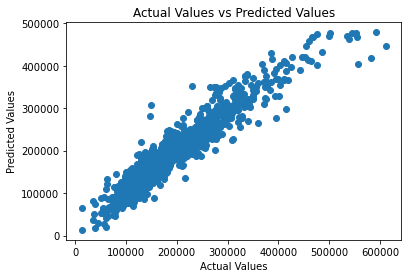

In [33]:
plt.scatter(y_new_train, lr2.predict(X_new_train_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

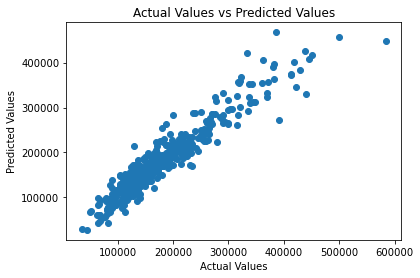

In [34]:
plt.scatter(y_new_test, lr2.predict(X_new_test_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

### LASSO ###

In [35]:
lasso2 = LassoCV(alphas = np.arange(0.001,10,1))
lasso2.fit(X_new_train_scaled,y_new_train)

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]))

In [36]:
print(f"Training R2: {lasso2.score(X_new_train_scaled, y_new_train)}")
print(f"Testing R2: {lasso2.score(X_new_test_scaled, y_new_test)}")
print(f"Cross val R2: {cross_val_score(lasso2, X_new_train_scaled, y_new_train).mean()}")

Training R2: 0.9061717062954786
Testing R2: 0.9049528196946659
Cross val R2: 0.8911914027496041


In [37]:
print(f"Training RMSE: {mean_squared_error(y_new_train, lasso2.predict(X_new_train_scaled))**0.5}")
print(f"Testing RMSE: {mean_squared_error(y_new_test, lasso2.predict(X_new_test_scaled))**0.5}")
print(f"Cross val RMSE: {cross_val_score(lasso2, X_new_train_scaled, y_new_train, scoring='neg_root_mean_squared_error').mean()*-1}")

Training RMSE: 24479.997611383627
Testing RMSE: 23767.467832085993
Cross val RMSE: 26203.262335786374


Model performs ideally and better than the linear regression model. 

In [38]:
lasso2.intercept_

183208.15690104163

Lasso model states that the baseline of homes would start at $183,208

In [39]:
lasso2_features = pd.Series(lasso2.coef_,index=X_new_train_scaled.columns)
lasso2_features[lasso2_features > 1].sort_values(ascending=False)[:10]

garage_cond_TA          18061.585112
gr_liv_area             14780.184460
home_sqft               13097.930810
overall_qual            12080.943396
total_bsmt_sf           11868.066330
garage_cond_Fa           7942.312274
garage_area              7280.124592
year_built               7162.354421
year_remod/add           7094.404299
neighborhood_StoneBr     6529.624004
dtype: float64

In [40]:
lasso2_features[lasso2_features < 0].sort_values()[:10]

garage_qual_TA    -24052.336633
exter_qual_TA     -20109.395303
exter_qual_Gd     -19392.628029
kitchen_qual_TA   -13954.047866
garage_qual_Fa    -13453.438135
kitchen_qual_Gd   -11531.987425
bsmt_qual_Gd      -10288.805099
bsmt_qual_TA       -9009.035081
fireplace_qu_NA    -6480.098164
garage_qual_Gd     -6383.380014
dtype: float64

Looked at coefficients for top and bottom 10 impacted features to see their affect on sale price

#### Note: ####
Separated lasso features that are greater than 1 and less than 0 to view all columns and coefficients.

There are a total of 82 lasso features:
- 35 features are greater than 1
- 44 features are less than 0
- 3 features are equal to 0

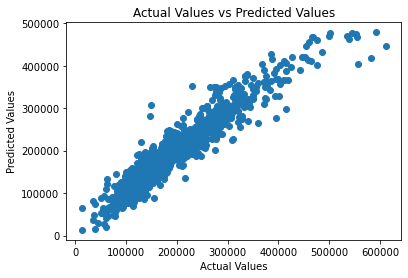

In [41]:
plt.scatter(y_new_train, lasso2.predict(X_new_train_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

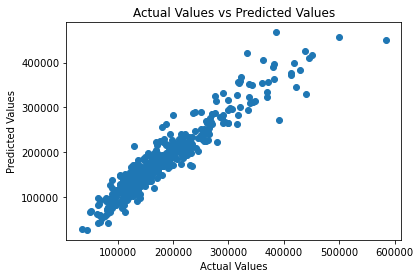

In [42]:
plt.scatter(y_new_test, lasso2.predict(X_new_test_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

### LASSO TRANSFORMED ###

In [43]:
tt2 = TransformedTargetRegressor(regressor=lasso2, func=np.log, inverse_func=np.exp)
tt2.fit(X_new_train_scaled,y_new_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00])))

In [44]:
print(f"Training R2: {tt2.score(X_new_train_scaled, y_new_train)}")
print(f"Testing R2: {tt2.score(X_new_test_scaled, y_new_test)}")
print(f"Cross val R2: {cross_val_score(tt2.regressor, X_new_train_scaled, y_new_train).mean()}")

Training R2: 0.9258102369510703
Testing R2: 0.9283320168972654
Cross val R2: 0.8911914027496041


In [45]:
print(f"Training RMSE: {mean_squared_error(y_new_train, tt2.predict(X_new_train_scaled))**0.5}")
print(f"Testing RMSE: {mean_squared_error(y_new_test, tt2.predict(X_new_test_scaled))**0.5}")
print(f"Cross val RMSE: {cross_val_score(tt2.regressor, X_new_train_scaled, y_new_train, scoring='neg_root_mean_squared_error').mean()*-1}")

Training RMSE: 21767.89599670467
Testing RMSE: 20638.393439211537
Cross val RMSE: 26203.262335786374


Model is performing ideally

In [46]:
print(tt2.regressor_.intercept_)

tt2_features = pd.Series(tt2.regressor_.coef_,index=X_new_train_scaled.columns)
tt2_features[:5]

12.033669350404402


street_Pave             0.002437
neighborhood_Blueste   -0.001253
neighborhood_BrDale    -0.018959
neighborhood_BrkSide    0.000480
neighborhood_ClearCr    0.008370
dtype: float64

Looked at lasso with a transformed y- variable to make sale price more normally distributed but the coefficients weren't interpretable for my problem statement.

### RIDGE ###

In [47]:
ridge2 = RidgeCV(alphas= np.logspace(0,5,100))
ridge2.fit(X_new_train_scaled,y_new_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))

In [48]:
print(f"Training R2: {ridge2.score(X_new_train_scaled, y_new_train)}")
print(f"Testing R2: {ridge2.score(X_new_test_scaled, y_new_test)}")
print(f"Cross val R2: {cross_val_score(ridge2, X_new_train_scaled, y_new_train).mean()}")

Training R2: 0.9053630538090639
Testing R2: 0.9059962199591919
Cross val R2: 0.8914021978535309


In [49]:
print(f"Training RMSE: {mean_squared_error(y_new_train, ridge2.predict(X_new_train_scaled))**0.5}")
print(f"Testing RMSE: {mean_squared_error(y_new_test, ridge2.predict(X_new_test_scaled))**0.5}")
print(f"Cross val RMSE: {cross_val_score(ridge2, X_new_train_scaled, y_new_train, scoring='neg_root_mean_squared_error').mean()*-1}")

Training RMSE: 24585.260857530615
Testing RMSE: 23636.651655881542
Cross val RMSE: 26173.982684000446


Model is performing ideally

In [50]:
ridge2.intercept_

183208.15690104163

Lasso model states that the baseline of homes would start at $183,208

In [51]:
ridge2_features = pd.Series(ridge2.coef_,index=X_new_train_scaled.columns)
ridge2_features[ridge2_features > 1].sort_values(ascending=False)[:10]

gr_liv_area             13730.658985
home_sqft               13138.266789
overall_qual            12709.068889
total_bsmt_sf           11076.557724
year_remod/add           7134.443118
garage_area              6979.941544
year_built               6695.298084
neighborhood_StoneBr     6615.175045
neighborhood_NoRidge     4080.120347
neighborhood_NridgHt     3895.938327
dtype: float64

In [52]:
ridge2_features[ridge2_features < 0].sort_values()[:10]

exter_qual_TA     -16042.537273
exter_qual_Gd     -15636.516849
kitchen_qual_TA   -13632.367083
kitchen_qual_Gd   -11478.383912
bsmt_qual_Gd      -10020.431730
bsmt_qual_TA       -8495.322755
garage_qual_TA     -6250.218613
fireplace_qu_NA    -5561.664967
kitchen_qual_Fa    -4180.116002
exter_qual_Fa      -3332.994645
dtype: float64

Looked at coefficients for top and bottom 10 impacted features to see their affect on sale price

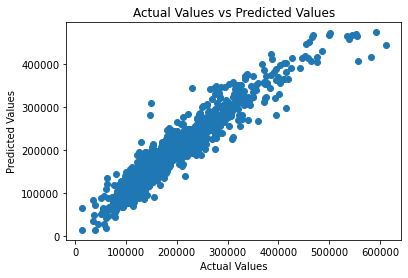

In [53]:
plt.scatter(y_new_train, ridge2.predict(X_new_train_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

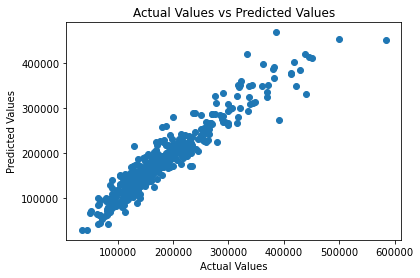

In [54]:
plt.scatter(y_new_test, ridge2.predict(X_new_test_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

### ELASTIC NET ###

In [55]:
EN2 = ElasticNet()
EN2.fit(X_new_train_scaled,y_new_train)

ElasticNet()

In [56]:
print(f"Training R2: {EN2.score(X_new_train_scaled, y_new_train)}")
print(f"Testing R2: {EN2.score(X_new_test_scaled, y_new_test)}")
print(f"Cross val R2: {cross_val_score(EN2, X_new_train_scaled, y_new_train).mean()}")

Training R2: 0.8800163471672575
Testing R2: 0.8945132267005443
Cross val R2: 0.870243508106563


In [57]:
print(f"Training RMSE: {mean_squared_error(y_new_train, EN2.predict(X_new_train_scaled))**0.5}")
print(f"Testing RMSE: {mean_squared_error(y_new_test, EN2.predict(X_new_test_scaled))**0.5}")
print(f"Cross val RMSE: {cross_val_score(EN2, X_new_train_scaled, y_new_train, scoring='neg_root_mean_squared_error').mean()*-1}")

Training RMSE: 27682.512303473584
Testing RMSE: 25038.73017279522
Cross val RMSE: 28661.669878259505


Model is performing ideally

In [58]:
EN2.intercept_

183208.15690104166

In [59]:
EN2_features = pd.Series(EN2.coef_,index=X_new_train_scaled.columns)
EN2_features[EN2_features > 1].sort_values(ascending=False)[:10]

overall_qual            10397.063206
home_sqft                9822.864884
gr_liv_area              7685.715917
total_bsmt_sf            7124.337410
neighborhood_StoneBr     5896.696446
1st_flr_sf               5532.730869
neighborhood_NridgHt     5453.637650
year_remod/add           5410.618902
garage_area              5280.581195
mas_vnr_area             5096.677222
dtype: float64

In [60]:
EN2_features[EN2_features < 0].sort_values()[:18]

kitchen_qual_TA        -5235.777549
exter_qual_TA          -4961.247817
bsmt_qual_Gd           -4516.000748
fireplace_qu_NA        -3581.707870
kitchen_qual_Gd        -3577.290935
bsmt_qual_TA           -3567.062510
neighborhood_NAmes     -2378.507336
exter_qual_Gd          -2268.155350
neighborhood_NWAmes    -1858.419603
neighborhood_OldTown   -1775.114235
neighborhood_BrDale    -1653.053944
exter_cond_Fa          -1462.245880
kitchen_qual_Fa        -1267.421074
neighborhood_Edwards   -1223.119140
neighborhood_MeadowV   -1189.255969
neighborhood_SawyerW   -1185.310965
bsmt_qual_Fa           -1137.263734
garage_qual_TA         -1007.102058
dtype: float64

In [61]:
EN2_features = pd.Series(EN2.coef_,index=X_new_train_scaled.columns)
EN2_df = pd.Series.to_frame(EN2_features[EN2_features > 1])
EN2_df.sort_values(ascending=False, by=0).head()

,0
overall_qual,10397.063206
home_sqft,9822.864884
gr_liv_area,7685.715917
total_bsmt_sf,7124.337410
neighborhood_StoneBr,5896.696446


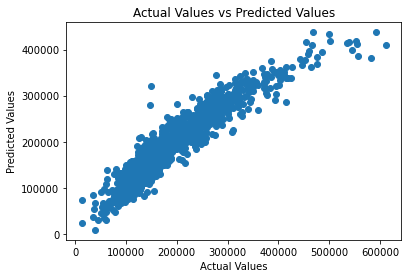

In [62]:
plt.scatter(y_new_train, EN2.predict(X_new_train_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

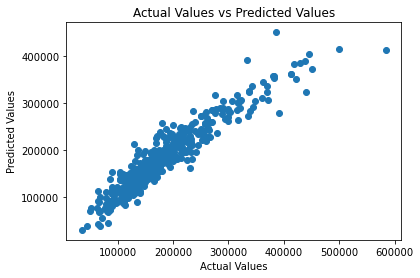

In [63]:
plt.scatter(y_new_test, EN2.predict(X_new_test_scaled))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values');

In [64]:
EN2_df = pd.Series.to_frame(EN2_features[EN2_features > 1000]).sort_values(ascending=False, by=0)
EN2_df.rename(columns = {0: 'Increases'}, inplace=True) 
EN2_df['Features'] = ['Overall Quality','Home Sq Ft', 'Above Ground Sq Ft', 'Stone Brook NBHD', 
                                 'Northridge Heights NBHD','Basement Sq Ft', 'Garage Square Ft', 'Remodel Date', 
                                 'Masonry Veneer Sq Ft','1st Floor Sq Ft', 'Baths', 'Year Built', 'Cars in Garage', 'Northridge NBHD',
                                 'Above Ground Rooms', 'Wood Shingles Roof', 'Porches', 'Good Fireplace', 'Garage Year Built', 'Green Hills NBHD',
                                 'Adj to Off-Site Feature', 'Crawford NBHD', 'Full Baths', 'Near Off-Site Feature', 'Central Air']

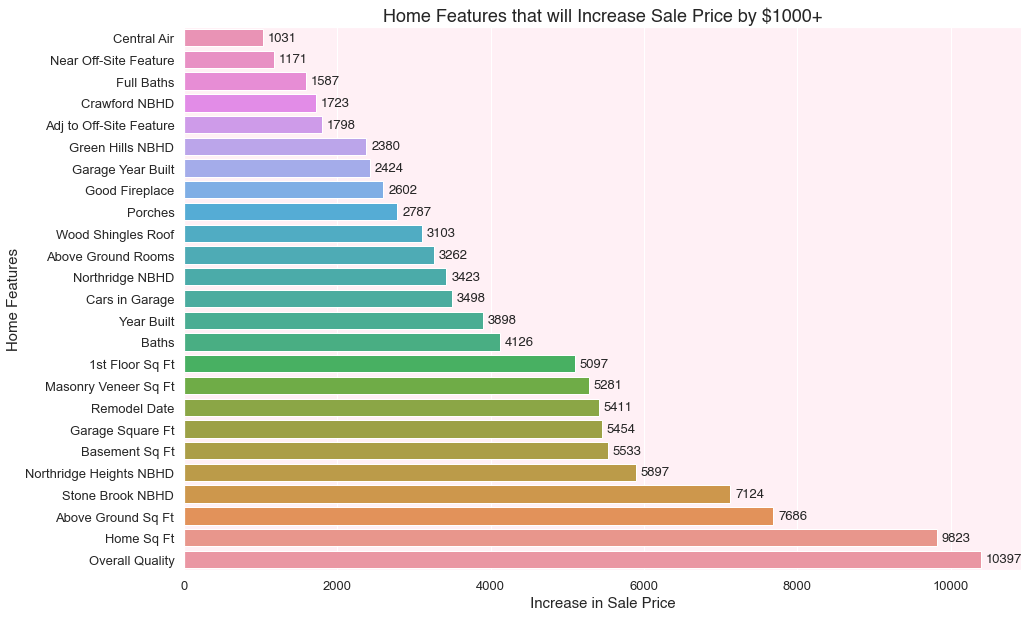

In [65]:
sns.set(rc={'axes.facecolor':'lavenderblush','figure.figsize':(15,10)})
plots = sns.barplot(y=EN2_df['Features'], x=EN2_df['Increases'], data=EN2_df)
for bars in plots.patches:
    plots.annotate("%.0f" % bars.get_width(), xy=(bars.get_width(), bars.get_y()+bars.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", fontname='Helvetica', fontsize=13)
plt.xlabel('Increase in Sale Price', fontsize=15, fontname='Helvetica')
plt.ylabel('Home Features', fontsize=15, fontname='Helvetica')
plt.title('Home Features that will Increase Sale Price by $1000+', fontsize=18, fontname='Helvetica')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plots.invert_yaxis()
plt.savefig('../figures/EN2_increase.png');

In [66]:
EN3_df = pd.Series.to_frame(EN2_features[EN2_features < 0].sort_values()[:18])
EN3_df.rename(columns = {0: 'Decreases'}, inplace=True) 
EN3_df['Features'] = ['Average Kitchen','Average Exterior Quality', 'Good Basement Quality','No Fireplace', '80-90 inch Basement', 'Good Kitchen Quality', 
                      'Names NBHD', 'Old Town NBHD','Edwards NBHD', 'Good Exterior Quality', 'Northwest Ames NBHD', 
                      'Briardale NBHD','Fair Exterior Condition', 'Meadow Village NBHD', '70-79 inch Basement', 'Fair Kitchen Quality',
                      'Sawyer West NBHD', 'No Basement']

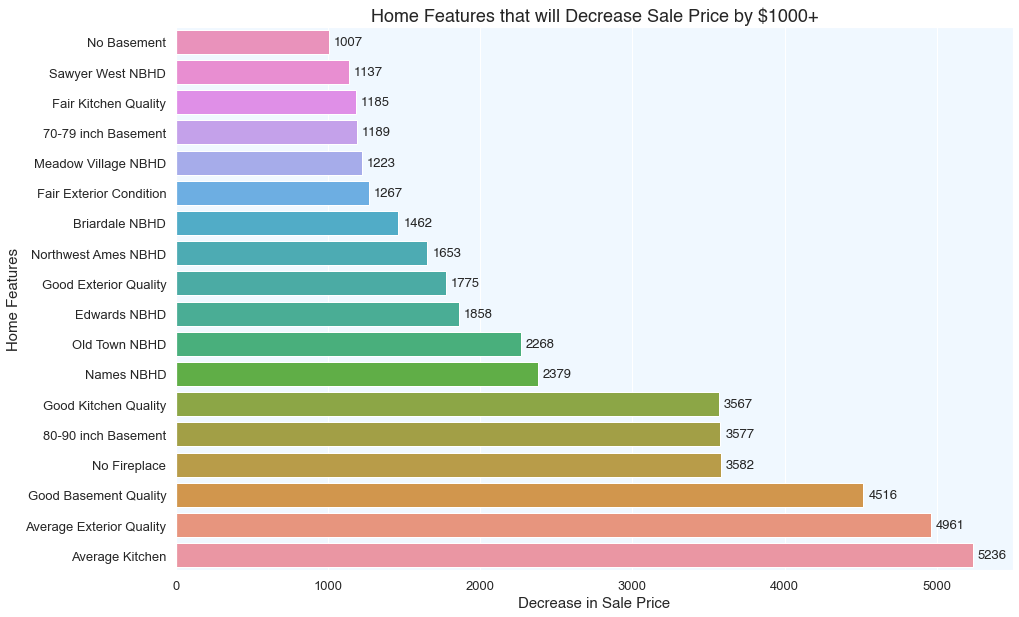

In [67]:
sns.set(rc={'axes.facecolor':'aliceblue','figure.figsize':(15,10)})
plots = sns.barplot(y=EN3_df['Features'], x=(-EN3_df['Decreases']), data=EN3_df)
for bars in plots.patches:
    plots.annotate("%.0f" % bars.get_width(), xy=(bars.get_width(), bars.get_y()+bars.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", fontname='Helvetica', fontsize=13)
plt.xlabel('Decrease in Sale Price', fontsize=15, fontname='Helvetica')
plt.ylabel('Home Features', fontsize=15, fontname='Helvetica')
plt.title('Home Features that will Decrease Sale Price by $1000+', fontsize=18, fontname='Helvetica')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plots.invert_yaxis()
plt.savefig('../figures/EN3_decrease.png');

#### Utilized Elastic NET as my final model because it combines Lasso penalties on irrelevant features and Ridge penalties on coefficients. It is a balance between feature elimination and feature coefficient reduction.

# Prediction #

In [68]:
test2 = test[list(X_new_train.columns)]
test2 = si2.transform(test2)
test_filled = pd.DataFrame(test2, columns = X_new_train.columns)
test_encoded = smart_encoder2.transform(test_filled)
test_encoded = pd.DataFrame(test_encoded, columns=smart_encoder2.get_feature_names_out())
test_scaled = ss2.transform(test_encoded)
test_scaled = pd.DataFrame(test_scaled, columns=X_new_train_encoded.columns)

#### Submission 1 (ElasticNet): ####

In [69]:
test_id = test['id']

preds = EN2.predict(test_scaled)
preds = pd.DataFrame(preds, columns = ['saleprice'])

preds.insert(loc = 0, column = 'id', value = test_id)

preds.head()

preds.to_csv('../datasets/submissions/EN2.csv', index = False)

#### Kaggle Submission 2 (Lasso): ####

In [70]:
test_id1 = test['id']

preds1 = lasso2.predict(test_scaled)
preds1 = pd.DataFrame(preds1, columns = ['saleprice'])

preds1.insert(loc = 0, column = 'id', value = test_id)

preds1.head()

preds1.to_csv('../datasets/submissions/lasso2.csv', index = False)

#### Kaggle Submission 3 (Ridge): ####

In [71]:
test_id2 = test['id']

preds2 = ridge2.predict(test_scaled)
preds2 = pd.DataFrame(preds2, columns = ['saleprice'])

preds2.insert(loc = 0, column = 'id', value = test_id)

preds2.head()

preds2.to_csv('../datasets/submissions/ridge2.csv', index = False)

#### Extra Kaggle Submission 4 (Lasso Transformed): ####

In [72]:
test_id3 = test['id']

preds3 = tt2.predict(test_scaled)
preds3 = pd.DataFrame(preds, columns = ['saleprice'])

preds3.insert(loc = 0, column = 'id', value = test_id)

preds3.head()

preds3.to_csv('../datasets/submissions/lasso_transf.csv', index=False)

## Conclusion and Recommendations

Homeowners looking to sell their home should focus on features that will increase the value of their home and combat features that will have a significant decrease in their sale price. The features that have at least a $1,000 impact include increasing home square footage, garage square footage, and/ or masonry veneer square footage; adding baths, porches, a fireplace, and/or central air; updating kitchen, exterior, and/or basement quality. Some of these updates may also improve the overall quality of the home and update add a remodel date that also has a positive impact on the value of a home. Prior to making any of these updates, a homeowner needs to determine the cost to complete some of these updates and what their return on investment would be. Also, they should compare their home to the homes in their neighborhood to get an understanding of sale prices of homes comparable to their own and where they lie in terms of quality of their home.